In [1]:
import pandas as pd
import numpy as np
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.patches as mpatches
import matplotlib

# Liability threshold model

In [98]:
f = h5py.File("../results/sim1/train_test_m_500_h2_0.67_EXTRA_new_rand_env.hdf5","r")

In [99]:
list(f.attrs)

['liability_thresh']

In [100]:
f.keys()

<KeysViewHDF5 ['gene_plus_env', 'test_data', 'train_cases', 'train_controls']>

In [106]:
sns.set_context("poster")
sns.set_style("white")
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 

In [107]:
f.attrs['liability_thresh']

1.6712799991335705

In [108]:
arr = f["gene_plus_env"][()]
norm = stats.zscore(arr)

In [109]:
thresh_norm = norm[np.where(arr == f.attrs['liability_thresh'])[0]]

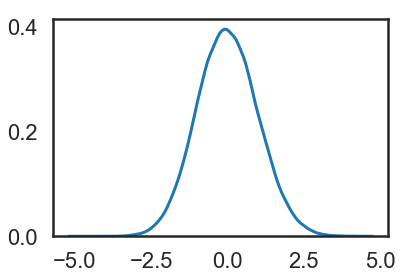

In [110]:
points = sns.kdeplot(norm).get_lines()[0].get_data()

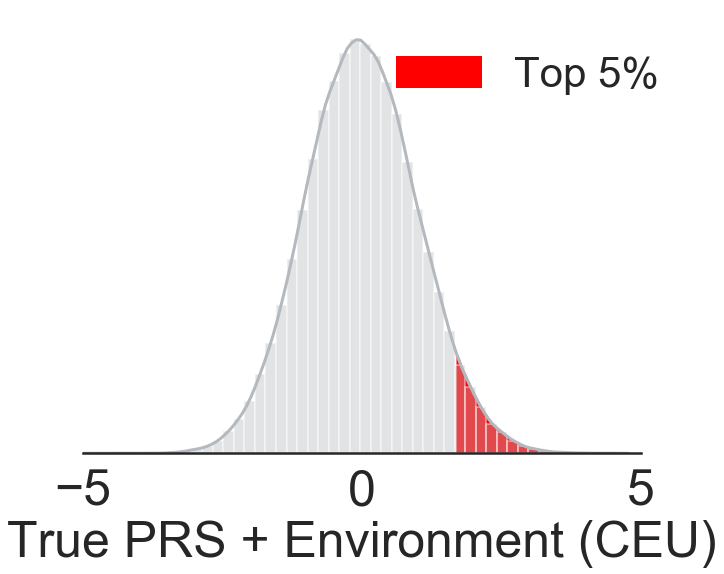

In [117]:
plt.figure(figsize=(10,8))
ax = plt.axes()

sns.distplot(norm,color="#B4B9BF",ax=ax)

x = points[0]
y = points[1]
plt.fill_between(x,y, where = x >=thresh_norm, color='r')

ax.yaxis.set_major_locator(plt.NullLocator())
ax.set_xlim(-5,5)
ax.set_xlabel("True PRS + Environment (CEU)",fontsize=50)
ax.tick_params(axis='both', which='major', labelsize=50)
ax.tick_params(axis='both', which='minor', labelsize=50)
red_patch = mpatches.Patch(color='red', label='Top 5%',)
plt.legend(handles=[red_patch],frameon=False,loc=1,bbox_to_anchor=(1.1,1),fontsize=42)

sns.despine(left=True)
# plt.tight_layout()
plt.savefig("/Users/taylorcavazos/Desktop/liability_thresh.png",dpi=800,bbox_inches="tight")
plt.show()

# Empirical and True PRS

In [1]:
def load_data(sim,m,h2):
    sim_dict = {}
    
    prs_anc = pd.read_csv("../results/sim{}/admix_afr_amer_m_{}_h2_{}_r2_0.2_p_0.01.prop.anc.PRS".format(sim,m,h2),sep="\t",index_col=0)
#     total_anc = pd.read_csv("../results/sim{}/admix_afr_amer.prop.anc".format(sim),sep="\t",index_col=0)
    sim_dict["PRS_ANC"] = prs_anc
#     sim_dict["TOTAL_ANC"] = total_anc
    
    sum_stats = pd.read_csv("../results/sim{}/emp_prs/comm_maf_0.01_sum_stats_m_{}_h2_{}.txt".format(sim,m,h2),index_col=0,sep="\t")
    emp_prs = h5py.File("../results/sim{}/emp_prs/emp_prs_m_{}_h2_{}_ld_CEU_GWAS_r2_0.2_p0.01.hdf5".format(sim,m,h2),"r")
    prs_vars = np.loadtxt("../results/sim{}/emp_prs/clumped_prs_vars_m_{}_h2_{}_ld_CEU_GWAS_r2_0.2_p0.01.txt".format(sim,m,h2))
    sim_dict["SS"] = sum_stats
    sim_dict["EMP_PRS"] = emp_prs
    sim_dict["PRS_VARS"] = prs_vars
    
    true_prs = h5py.File("../results/sim{}/true_prs/prs_m_{}_h2_{}.hdf5".format(sim,m,h2),"r")
    labels = h5py.File("../results/sim{}/true_prs/train_test_m_{}_h2_{}.hdf5".format(sim,m,h2),"r")
    sim_dict["TRUE_PRS"] = true_prs
    sim_dict["LABELS"] = labels
    
    return sim_dict

In [119]:
sim_dict = load_data(3,500,0.67)

In [120]:
def extract_data(sim,m,h2):
    sim_dict = load_data(sim,m,h2)
    test_locs = sim_dict["LABELS"]["test_data"][()]
    true_prs_labels = sim_dict["TRUE_PRS"]["labels"][()]
    test_locs_ceu = []
    test_locs_yri = []
    test_locs_admix = []
    for ind in test_locs:
        if "msp" in true_prs_labels[ind].astype(str):
            test_locs_ceu.append(ind)
        elif "yri" in true_prs_labels[ind].astype(str):
            test_locs_yri.append(ind)
        else:
            test_locs_admix.append(ind)
    test_locs_ceu = np.array(test_locs_ceu)
    test_locs_admix = np.array(test_locs_admix)

    anc_w_ind = sim_dict["PRS_ANC"].reset_index()
    low_eur = np.array(anc_w_ind[anc_w_ind["Prop_CEU"]<=0.2].index)
    mid_eur = np.array(anc_w_ind[(anc_w_ind["Prop_CEU"]>0.2)&(anc_w_ind["Prop_CEU"]<0.8)].index)
    high_eur = np.array(anc_w_ind[anc_w_ind["Prop_CEU"]>=0.8].index)

    emp_prs = sim_dict["EMP_PRS"]["X"][()]
    emp_prs_std = stats.zscore(emp_prs)

    true_prs = sim_dict["TRUE_PRS"]["X"][()]
    true_prs_std = stats.zscore(true_prs)
    return {"emp_prs_std":emp_prs_std, "true_prs_std": true_prs_std,
            "test_locs_ceu":test_locs_ceu,"test_locs_admix":test_locs_admix,
            "low_eur":low_eur,"mid_eur":mid_eur,"high_eur":high_eur}

In [121]:
def make_plot(prs_std,test_locs_ceu,test_locs_admix,low_eur,mid_eur,high_eur,ax):
    sns.distplot(prs_std[test_locs_ceu],color="#103c42",label="European-only",
            hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3},ax=ax)
    sns.distplot(prs_std[test_locs_admix[high_eur]],color="#02576c",label="CEU >= 80%",
                 hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3},ax=ax)
    sns.distplot(prs_std[test_locs_admix[mid_eur]],color="#05a19c",label="80% > CEU > 20%",
                hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3},ax=ax)
    sns.distplot(prs_std[test_locs_admix[low_eur]],color="#ffe837",label="CEU <= 20%",
                hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3},ax=ax)
    ax.legend().remove()
    ax.set_xlim(-5,5)
#     ax.set_xticklabels(ax.get_xticks(),fontsize=20)

In [122]:
sns.set_context("poster")
sns.set_style("white")
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 

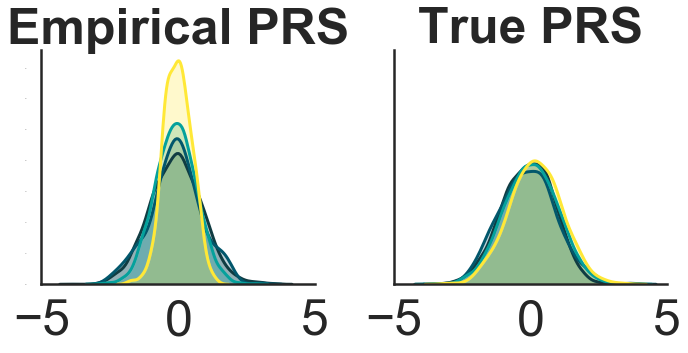

In [125]:
fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(10,5),sharey=True,)
sim3 = extract_data(3,500,0.67)
make_plot(sim3["emp_prs_std"],sim3["test_locs_ceu"],sim3["test_locs_admix"],sim3["low_eur"],sim3["mid_eur"],sim3["high_eur"],axes[0])
make_plot(sim3["true_prs_std"],sim3["test_locs_ceu"],sim3["test_locs_admix"],sim3["low_eur"],sim3["mid_eur"],sim3["high_eur"],axes[1])

for ax in axes.flat:
    sns.despine(ax=ax)
    ax.tick_params(axis="y", labelsize=0)
    ax.tick_params(axis='x', which='major', labelsize=50)
ax.tick_params(axis='both', which='minor', labelsize=50)
fig.tight_layout(h_pad= 0,w_pad=1.5)
axes[0].set_title("Empirical PRS",fontweight="bold",fontsize=50)
axes[1].set_title("True PRS",fontweight="bold",fontsize=50)
# axes[0].set_title("",fontweight="bold",fontsize=50)
# axes[1].set_title("",fontweight="bold",fontsize=50)
# axes[0].set_ylabel("Density")
plt.savefig("/Users/taylorcavazos/Desktop/sim3_dists.png",dpi=800,bbox_inches="tight")

plt.show()

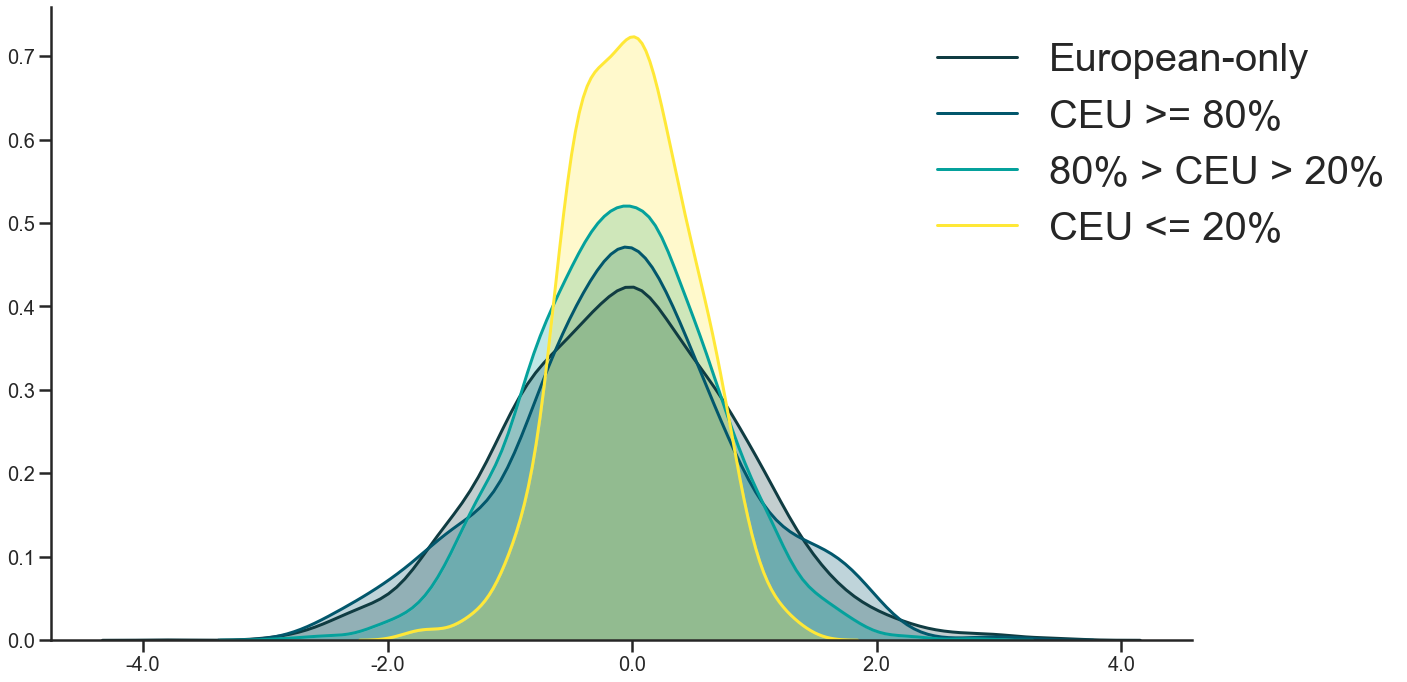

In [156]:
fig,axes = plt.subplots(ncols=1,nrows=1,figsize=(20,10))

sns.distplot(emp_prs_std[test_locs_ceu],color="#103c42",label="European-only",
            hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3},ax=axes)
sns.distplot(emp_prs_std[test_locs_admix[high_eur]],color="#02576c",label="CEU >= 80%",
             hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3},ax=axes)
sns.distplot(emp_prs_std[test_locs_admix[mid_eur]],color="#05a19c",label="80% > CEU > 20%",
            hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3},ax=axes)
sns.distplot(emp_prs_std[test_locs_admix[low_eur]],color="#ffe837",label="CEU <= 20%",
            hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3},ax=axes)

# sns.distplot(true_prs_std[test_locs_ceu],color="#103c42",label="European-only",
#             hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3},ax=axes[1])
# sns.distplot(true_prs_std[test_locs_admix[high_eur]],color="#02576c",label="CEU >= 80%",
#              hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3},ax=axes[1])
# sns.distplot(true_prs_std[test_locs_admix[mid_eur]],color="#05a19c",label="80% > CEU > 20%",
#             hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3},ax=axes[1])
# sns.distplot(true_prs_std[test_locs_admix[low_eur]],color="#ffe837",label="CEU <= 20%",
#             hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3},ax=axes[1])


axes.set_xticklabels(axes.get_xticks(),fontsize=20)
axes.set_yticklabels(np.round(axes.get_yticks(),2),fontsize=20)

axes.legend(frameon=False,loc=1,bbox_to_anchor=(1.2,1),fontsize=40)

fig.tight_layout(h_pad= 2,w_pad=0.5)
sns.despine()
plt.show()

# Correlation plot

In [46]:
def make_reg(sim):
    sns.regplot(sim["emp_prs_std"][sim["test_locs_ceu"]],sim["true_prs_std"][sim["test_locs_ceu"]],color="#103c42")
    sns.regplot(sim["emp_prs_std"][sim["test_locs_admix"][sim["high_eur"]]],sim["true_prs_std"][sim["test_locs_admix"][sim["high_eur"]]],color="#02576c")
    sns.regplot(sim["emp_prs_std"][sim["test_locs_admix"][sim["mid_eur"]]],sim["true_prs_std"][sim["test_locs_admix"][sim["mid_eur"]]],color="#05a19c")
    sns.regplot(sim["emp_prs_std"][sim["test_locs_admix"][sim["low_eur"]]],sim["true_prs_std"][sim["test_locs_admix"][sim["low_eur"]]],color="#ffe837")
    plt.show()

In [47]:
sns.set_context("poster")
sns.set_style("white")
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 

In [82]:
def make_scatter(sim,ax,title):
    ax.scatter(sim["emp_prs_std"][sim["test_locs_ceu"]],sim["true_prs_std"][sim["test_locs_ceu"]],s=30,alpha=1,color="#103c42")
    ax.scatter(sim["emp_prs_std"][sim["test_locs_admix"][sim["high_eur"]]],sim["true_prs_std"][sim["test_locs_admix"][sim["high_eur"]]],s=30,alpha=1,color="#02576c")
    ax.scatter(sim["emp_prs_std"][sim["test_locs_admix"][sim["mid_eur"]]],sim["true_prs_std"][sim["test_locs_admix"][sim["mid_eur"]]],s=30,alpha=1,color="#05a19c")
    ax.scatter(sim["emp_prs_std"][sim["test_locs_admix"][sim["low_eur"]]],sim["true_prs_std"][sim["test_locs_admix"][sim["low_eur"]]],s=30,alpha=1,color="#ffe837")
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
#     ax.set_xticks(np.arange(-5,7.5,2.5))
#     ax.set_yticks(np.arange(-5,7.5,2.5))
#     ax.set_ylim(-5,5)
    ax.set_title(title,fontsize=50,fontweight="bold")
#     ax.set_xlabel("Empirical PRS", fontsize=50)
    ax.tick_params(axis='both', which='major', labelsize=50)
    ax.tick_params(axis='both', which='minor', labelsize=50)

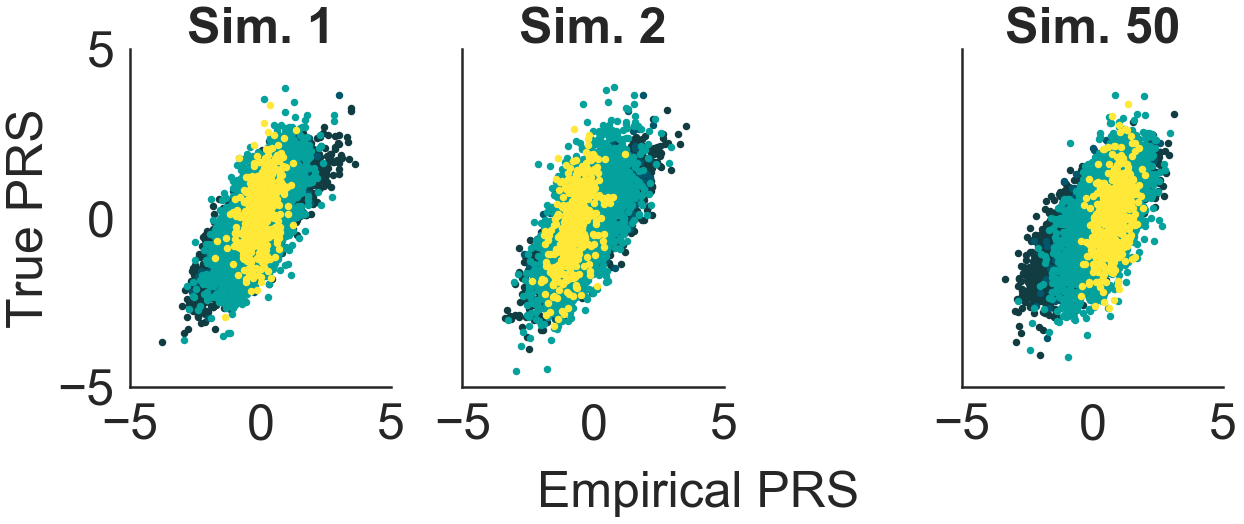

In [97]:
fig = plt.figure(figsize=(20,18))

ax1 = plt.subplot2grid((3, 8), (0, 0),colspan=2)
ax2 = plt.subplot2grid((3, 8), (0, 2),colspan=2,sharey=ax1)
ax3 = plt.subplot2grid((3, 8), (0, 4),colspan=1)
ax4 = plt.subplot2grid((3, 8), (0, 5),colspan=2,sharey=ax1)

make_scatter(extract_data(3,500,0.67),ax1,"Sim. 1")

make_scatter(extract_data(11,500,0.67),ax2, "Sim. 2")
make_scatter(extract_data(23,500,0.67),ax4, "Sim. 50")
sns.despine()

for ax in [ax2,ax4]:
    plt.setp(ax.get_yticklabels(), visible=False)
ax3.set_frame_on(False)
ax3.tick_params(labelleft=False,labelbottom=False)
ax1.set_ylabel("True PRS",fontsize=50)
fig.suptitle("Empirical PRS",fontsize=50,y=0.62)
plt.tight_layout(pad=1.2)
plt.savefig("/Users/taylorcavazos/Desktop/corrplots.png",dpi=800,bbox_inches="tight")
plt.show()

# Table Summarizing Kaiser Results

In [5]:
df = pd.DataFrame({"Population":["Kaiser European","Kaiser European","Kaiser African American","Kaiser African American","Kaiser African American","Kaiser African American"],
             "CEU Ancestry at PRS Variants": ["100%","100%",">30%",">30%","<=30%","<=30%"],
              "# Samples (Cases)": ["11649 (6196)","11649 (6196)","334 (182)","334 (182)","1222 (810)","1222 (810)"],
              "AUC": [0.68,0.68,0.63,0.63,0.54,0.54],
              "Percentile": ["25th","75th"]*3,
              "OR": [0.52,2.00,0.79,1.47,0.92,1.08],
              "95% CI": ["(0.48,0.57)","(1.82,2.20)","(0.47,1.31)","(0.77,1.24)","(0.68,1.24)","(0.77,1.50)"],
              "P": ["2.4e-42","1.8e-46","0.36","0.24","0.58","0.67"],})

In [8]:
print(df.to_latex(index=False))

\begin{tabular}{lllrlrll}
\toprule
              Population & CEU Ancestry at PRS Variants & \# Samples (Cases) &   AUC & Percentile &    OR &       95\% CI &        P \\
\midrule
         Kaiser European &                         100\% &      11649 (6196) &  0.68 &       25th &  0.52 &  (0.48,0.57) &  2.4e-42 \\
         Kaiser European &                         100\% &      11649 (6196) &  0.68 &       75th &  2.00 &  (1.82,2.20) &  1.8e-46 \\
 Kaiser African American &                         >30\% &         334 (182) &  0.63 &       25th &  0.79 &  (0.47,1.31) &     0.36 \\
 Kaiser African American &                         >30\% &         334 (182) &  0.63 &       75th &  1.47 &  (0.77,1.24) &     0.24 \\
 Kaiser African American &                        <=30\% &        1222 (810) &  0.54 &       25th &  0.92 &  (0.68,1.24) &     0.58 \\
 Kaiser African American &                        <=30\% &        1222 (810) &  0.54 &       75th &  1.08 &  (0.77,1.50) &     0.67 \\
\bottomrul

# LA specific weighting true PRS

In [2]:
def load_data(sim,m,h2):
    sim_dict = {}
    
    prs_anc = pd.read_csv("../results/sim{}/admix_afr_amer_m_{}_h2_{}_r2_0.2_p_0.01.prop.anc.PRS".format(sim,m,h2),sep="\t",index_col=0)
    total_anc = pd.read_csv("../results/sim{}/admix_afr_amer.prop.anc".format(sim),sep="\t",index_col=0)
    sim_dict["PRS_ANC"] = prs_anc
    sim_dict["TOTAL_ANC"] = total_anc
    
#     sum_stats = pd.read_csv("../results/sim{}/emp_prs/comm_maf_0.01_sum_stats_m_{}_h2_{}.txt".format(sim,m,h2),index_col=0,sep="\t")
    emp_prs = h5py.File("../results/sim{}/emp_prs/emp_prs_m_{}_h2_{}_ld_CEU_GWAS_r2_0.2_p0.01.hdf5".format(sim,m,h2),"r")
    emp_prs_weight = h5py.File("../results/sim{}/emp_prs/emp_prs_m_{}_h2_{}_ld_CEU_GWAS_r2_0.2_p0.01_LA_weights.hdf5".format(sim,m,h2),"r")
    emp_prs_weight2 = h5py.File("../results/sim{}/emp_prs/emp_prs_m_500_h2_0.67_ld_CEU_GWAS_r2_0.2_p0.01_LA_risk_weights.hdf5".format(sim,m,h2),"r")
#     prs_vars = np.loadtxt("../results/sim{}/emp_prs/clumped_prs_vars_m_{}_h2_{}_ld_CEU_GWAS_r2_0.2_p0.01.txt".format(sim,m,h2))
#     sim_dict["SS"] = sum_stats
    sim_dict["EMP_PRS"] = emp_prs
    sim_dict["EMP_PRS_WEIGHT"] = emp_prs_weight
    sim_dict["EMP_PRS_RISK_WEIGHT"] = emp_prs_weight2
#     sim_dict["PRS_VARS"] = prs_vars
    
    true_prs = h5py.File("../results/sim{}/true_prs/prs_m_{}_h2_{}.hdf5".format(sim,m,h2),"r")
    labels = h5py.File("../results/sim{}/true_prs/train_test_m_{}_h2_{}.hdf5".format(sim,m,h2),"r")
    sim_dict["TRUE_PRS"] = true_prs
    sim_dict["LABELS"] = labels
    
    return sim_dict

In [3]:
def extract_data(sim,m,h2):
    sim_dict = load_data(sim,m,h2)
    test_locs = sim_dict["LABELS"]["test_data"][()]
    true_prs_labels = sim_dict["TRUE_PRS"]["labels"][()]
    test_locs_ceu = []
    test_locs_yri = []
    test_locs_admix = []
    for ind in test_locs:
        if "msp" in true_prs_labels[ind].astype(str):
            test_locs_ceu.append(ind)
        elif "yri" in true_prs_labels[ind].astype(str):
            test_locs_yri.append(ind)
        else:
            test_locs_admix.append(ind)
    test_locs_ceu = np.array(test_locs_ceu)
    test_locs_admix = np.array(test_locs_admix)

    anc_w_ind = sim_dict["PRS_ANC"].reset_index()
    low_eur = np.array(anc_w_ind[anc_w_ind["Prop_CEU"]<=0.2].index)
    mid_eur = np.array(anc_w_ind[(anc_w_ind["Prop_CEU"]>0.2)&(anc_w_ind["Prop_CEU"]<0.8)].index)
    mid_eur1 = np.array(anc_w_ind[(anc_w_ind["Prop_CEU"]>0.2)&(anc_w_ind["Prop_CEU"]<=0.4)].index)
    mid_eur2 = np.array(anc_w_ind[(anc_w_ind["Prop_CEU"]>0.4)&(anc_w_ind["Prop_CEU"]<=0.6)].index)
    mid_eur3 = np.array(anc_w_ind[(anc_w_ind["Prop_CEU"]>0.6)&(anc_w_ind["Prop_CEU"]<=0.8)].index)
    high_eur = np.array(anc_w_ind[anc_w_ind["Prop_CEU"]>0.8].index)

    emp_prs = sim_dict["EMP_PRS"]["X"][()]
    emp_prs_std = stats.zscore(emp_prs)
    
    emp_prs_weight = sim_dict["EMP_PRS_WEIGHT"]["X"][()]
    emp_prs_weight_std = stats.zscore(emp_prs_weight)
    
    emp_prs_weight_risk = sim_dict["EMP_PRS_RISK_WEIGHT"]["X"][()]
    emp_prs_weight_risk_std = stats.zscore(emp_prs_weight_risk)

    true_prs = sim_dict["TRUE_PRS"]["X"][()]
    true_prs_std = stats.zscore(true_prs)
    return {"true_prs_std": true_prs_std,
            "true_prs": true_prs,
            "emp_prs_std": emp_prs_std,
            "emp_prs": emp_prs,
            "emp_prs_weight_std": emp_prs_weight_std,
            "emp_prs_weight": emp_prs_weight,
            "emp_prs_risk_weight_std": emp_prs_weight_risk_std,
            "emp_prs_risk_weight": emp_prs_weight_risk,
            "test_locs_ceu":test_locs_ceu,"test_locs_admix":test_locs_admix,
            "low_eur":low_eur,"mid_eur1":mid_eur1,"mid_eur2":mid_eur2,
            "mid_eur3":mid_eur3,"high_eur":high_eur, "mid_eur":mid_eur}

In [4]:
def make_plot(prs_std,test_locs_ceu,test_locs_admix,low_eur,mid_eur,high_eur,ax,line="-"):
    sns.distplot(prs_std[test_locs_ceu],color="#103c42",label="European-only",
            hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3, 'linestyle':line},ax=ax)
    sns.distplot(prs_std[test_locs_admix[high_eur]],color="#02576c",label="CEU >= 80%",
                 hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3, 'linestyle':line},ax=ax)
    sns.distplot(prs_std[test_locs_admix[mid_eur]],color="#05a19c",label="80% > CEU > 20%",
                hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3, 'linestyle':line},ax=ax)
    sns.distplot(prs_std[test_locs_admix[low_eur]],color="#ffe837",label="CEU <= 20%",
                hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3, 'linestyle':line},ax=ax)
    ax.legend().remove()
    ax.set_xlim(-5,5)
#     ax.set_xticklabels(ax.get_xticks(),fontsize=20)

In [58]:
result = extract_data(51,500,0.67)

In [66]:
load_data(52,500,0.67)["LABELS"]["test_data"][()]

array([166048, 163807,  65816, ..., 404997, 404998, 404999])

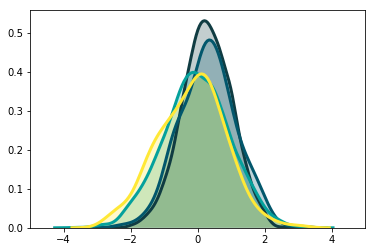

In [63]:
fig,ax = plt.subplots()
make_plot(result["true_prs_std"],result["test_locs_ceu"],
         result["test_locs_admix"],result["low_eur"],result["mid_eur"],result["high_eur"],ax)

IndexError: index 400002 is out of bounds for axis 0 with size 205000

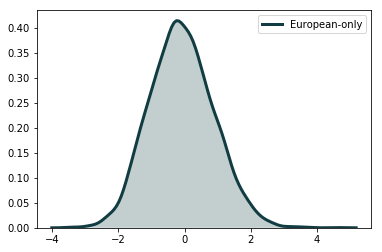

In [64]:
fig,ax = plt.subplots()
make_plot(result["emp_prs_std"],result["test_locs_ceu"],
         result["test_locs_admix"],result["low_eur"],result["mid_eur"],result["high_eur"],ax)

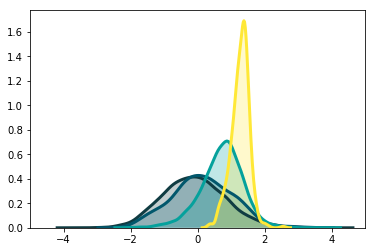

In [51]:
fig,ax = plt.subplots()
make_plot(result["emp_prs_weight_std"],result["test_locs_ceu"],
         result["test_locs_admix"]-200000,result["low_eur"],result["mid_eur"],result["high_eur"],ax)

In [52]:
from scipy import stats

In [53]:
true_prs = result["true_prs_std"]
emp_prs_weight = result["emp_prs_weight_std"]
emp_prs = result["emp_prs_std"]
test_ceu = result["test_locs_ceu"]
test_admix = result["test_locs_admix"]
low = result["low_eur"]
mid = result["mid_eur"]
mid1 = result["mid_eur1"]
mid2 = result["mid_eur2"]
mid3 = result["mid_eur3"]
high = result["high_eur"]

In [54]:
for arr in [low,mid,high]:
    print(stats.pearsonr(true_prs[test_admix][arr],emp_prs[test_admix-200000][arr])[0])

0.3169690513184815
0.4784376576883122
0.6619188764155441


In [55]:
for arr in [low,mid,high]:
    print(stats.pearsonr(true_prs[test_admix][arr],emp_prs_weight[test_admix-200000][arr])[0])

0.13995638974738595
0.3814846217539607
0.6592100354685766


In [56]:
true_prs = result["true_prs_std"]
emp_prs_weight = result["emp_prs_risk_weight_std"]
emp_prs = result["emp_prs_std"]
test_ceu = result["test_locs_ceu"]
test_admix = result["test_locs_admix"]
low = result["low_eur"]
mid = result["mid_eur"]
mid1 = result["mid_eur1"]
mid2 = result["mid_eur2"]
mid3 = result["mid_eur3"]
high = result["high_eur"]

In [57]:
for arr in [low,mid,high]:
    print(stats.pearsonr(true_prs[test_admix][arr],emp_prs_weight[test_admix-200000][arr])[0])

0.14348614734397022
0.40742496930532235
0.6531112027863313


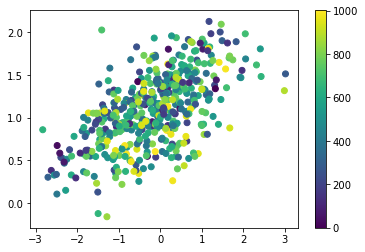

In [170]:
plt.scatter(true_prs[test_admix][low],emp_prs_weight[test_admix-200000][low],
           c = (diplo_counts.iloc[:,low]==3).sum())
plt.colorbar()
plt.show()

In [114]:
(1.103+0.997)/2

1.05

In [22]:
anc = pd.read_csv("../results/sim52/admix_afr_amer.result.PRS",sep="\t",index_col=0)

In [23]:
diplo_counts = anc.groupby((np.arange(len(anc.columns)) // 2) + 1, axis=1).sum().add_prefix('s')

In [24]:
(diplo_counts.iloc[:,low]==3).sum().mean()

590.521645021645

In [20]:
(diplo_counts.iloc[:,low]==4).sum().mean()

656.2034632034632

In [21]:
(diplo_counts.iloc[:,mid]==3).sum().mean()

1241.7448780487805

In [93]:
(diplo_counts.iloc[:,mid]==4).sum().mean()

639.3095121951219

In [91]:
(diplo_counts.iloc[:,high]==3).sum().mean()

1259.3584474885845

In [94]:
diplo_counts

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,...,s4991,s4992,s4993,s4994,s4995,s4996,s4997,s4998,s4999,s5000
1383,3,4,2,2,4,4,3,3,4,3,...,3,2,3,2,3,3,2,3,3,3
5619,3,4,2,2,4,4,3,3,4,3,...,3,2,3,2,3,3,2,3,3,3
6068,3,4,2,2,4,4,3,3,4,3,...,3,2,3,2,3,3,2,3,3,3
6946,3,4,2,2,4,4,3,3,4,3,...,3,2,3,2,3,3,2,3,3,3
7295,3,4,2,2,4,4,3,3,4,3,...,3,2,3,2,3,3,2,3,3,3
7537,3,4,2,2,4,4,3,3,4,3,...,3,2,3,2,3,3,2,3,3,3
8132,3,4,2,2,4,4,3,3,4,3,...,3,2,3,2,3,3,2,3,3,3
8213,3,4,2,2,4,4,3,3,4,3,...,3,2,3,2,3,3,2,3,3,3
9368,3,4,2,2,4,4,3,3,4,3,...,3,2,3,2,3,3,2,3,3,3
9874,3,4,2,2,4,4,3,3,4,3,...,3,2,3,2,3,3,2,3,3,3


In [137]:
prs_vars = np.loadtxt("../results/sim51/emp_prs/clumped_prs_vars_m_500_h2_0.67_ld_CEU_GWAS_r2_0.2_p0.01.txt")

In [138]:
ceu = pd.read_csv("../results/sim51/emp_prs/comm_maf_0.01_sum_stats_m_500_h2_0.67.txt",sep="\t",index_col=0)

In [139]:
yri = pd.read_csv("../results/sim51/emp_prs/yri_comm_maf_0.01_sum_stats_m_500_h2_0.67.txt",sep="\t",index_col=0)

In [140]:
yri.reindex(prs_vars).isna().all(axis=1).sum()

1093

In [142]:
ceu.index[:5]

Float64Index([7.0, 8.0, 60.0, 67.0, 73.0], dtype='float64', name='var_id')

In [150]:

best_yri = yri.loc[ceu.index[:5],:].sort_values(by="p-value").iloc[0,:]

In [148]:
OR

1.5060728744939271

In [149]:
pval

0.005448049131140954

In [151]:
OR,pval = best_yri

In [152]:
OR

1.5060728744939271

In [ ]:
    with open(vcf_file) as f:
        ind=0
        for line in f:
            if line[0] != "#":
                if ind % 1000 == 0: print("Looked at {} variants".format(ind))
                if ind in clumped_prs_vars:


In [ ]:
tree_LD_filt = tree_LD.simplify(filter_sites=True)
prs_vars = sum_stats[sum_stats["p-value"] < p_thresh].sort_values(by=["p-value"]).index
prs_vars_ld_pres = [var for var in prs_vars if var in var2mut.keys()]
ld_struct = find_ld_sites(tree_LD_filt,prs_vars_ld_pres,var2mut,mut2var,r2_threshold=r2,num_threads=num_threads)

In [ ]:
ld_struct = find_ld_sites(LD_info[0],[ind],LD_info[1],LD_info[2],r2_threshold=LD_info[3],num_threads=LD_info[4])
best_yri = sum_stats_yri.loc[ld_struct[ind],:].sort_values(by="p-value",ascending=True).iloc[0,:]
yri_weight,yri_pval = best_yri
yri_ind = best_yri.name

# Local Ancestry Weighting

In [5]:
import glob

In [6]:
sns.set_context("notebook")
sns.set(style = 'whitegrid', font_scale = 2)

In [7]:
full_df_prs = pd.DataFrame(columns = ["weight","train_corr","test_EUR_corr","test_ADMIX_corr",
                                 "ADMIX_low_eur_corr","ADMIX_mid_eur_corr","ADMIX_high_eur_corr"])
for f in glob.glob("../results/summary/corrs/*/*"):
    df = pd.read_csv(f,sep="\t",index_col=0)
    df.index = [f.split("_")[-1].split(".")[0]]
    df.loc[:,"sim"] = f.split("_")[-1].split(".")[0]
    
    df.loc[:,"m"] = int(f.split("_")[4])
    df.loc[:,"h2"] = float(f.split("_")[6])
    df.loc[:,"pval"] = float(f.split("_")[10])
    df.loc[:,"r2"] = float(f.split("_")[8])
    
    if "LA_weights" in f:
        df.loc[:,"weight"] = "Local ancestry \nspecific"
    elif "yri_weights" in f:
        df.loc[:,"weight"] = "African"
    else: df.loc[:,"weight"] = "European"
        
    full_df_prs = full_df_prs.append(df,ignore_index=False,sort=True)

In [8]:
def plot_correlation(data,axis,palette,title=""):
#     g = sns.boxplot(data = data,palette=palette,ax = axis)
    g = sns.violinplot(data = data,palette=palette,ax = axis,cut=0)
    g.set_xticks(np.arange(0,1.2,0.2))
    g.set_xticklabels("")
    axis.set_title(title,fontsize=38)
    return 

In [9]:
cols = ["test_EUR_corr","ADMIX_high_eur_corr",
                                 "ADMIX_mid_eur_corr",
                                 "ADMIX_low_eur_corr","weight"]

In [10]:
long_df = full_df_prs.melt(value_vars=cols[:-1],id_vars=["weight","sim","m","h2"])

In [11]:
import matplotlib.ticker as ticker

In [12]:
long_df_sub = long_df[long_df["weight"]!="African"]

In [52]:
import itertools
m = [200,500,1000]
h2 = [0.33,0.5,0.67]
pairs = list(itertools.product(h2,m))

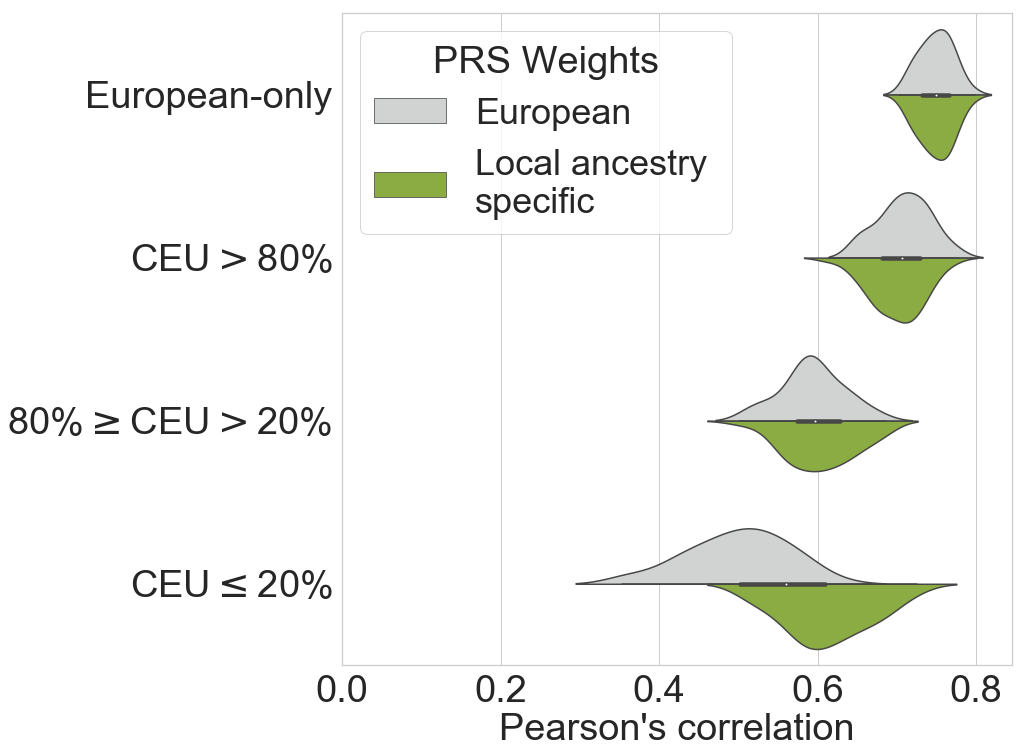

In [53]:
fig,ax = plt.subplots(figsize=(12,12))
g = sns.violinplot(y="variable",x="value",split=True,hue="weight",
                   data=long_df_sub[(long_df_sub["m"]==1000)&(long_df_sub["h2"]==0.67)],ax=ax,palette=["#D1D3D3","#90BD31"])
g.set_xticks(np.arange(0,1,0.2))
g.set_yticklabels(["European-only","CEU$>$80%","80%$\geq$CEU$>$20%", "CEU$\leq$20%"],
                 rotation=0,fontsize=38)
#sns.despine(right=True)
legend = plt.legend(frameon=True,title="PRS Weights",fontsize=36,fancybox=True)
plt.setp(legend.get_title(),fontsize=38)


ax.tick_params(axis='both', which='major', labelsize=38)
ax.tick_params(axis='both', which='minor', labelsize=38)

# plt.title("Local Ancestry Weighting ")
plt.ylabel("")
plt.xlabel("Pearson's correlation",fontsize=38)
# plt.savefig("/Users/taylorcavazos/Documents/Posters/ASHG2019/alt_layout_1/result4.png",dpi=1000,bbox_inches="tight")

# plt.savefig("/Users/taylorcavazos/Box Sync/local_anc_adjust.png",dpi=1000,bbox_inches="tight")


plt.show()


In [13]:
cols = ["test_EUR_corr","ADMIX_high_eur_corr",
                                 "ADMIX_mid_eur_corr",
                                 "ADMIX_low_eur_corr","weight"]

In [14]:
sns.set_context("notebook")
sns.set(style = 'whitegrid', font_scale = 2)

In [15]:
import itertools
m = [200,500,1000]
h2 = [0.33,0.5,0.67]
pairs = list(itertools.product(h2,m))

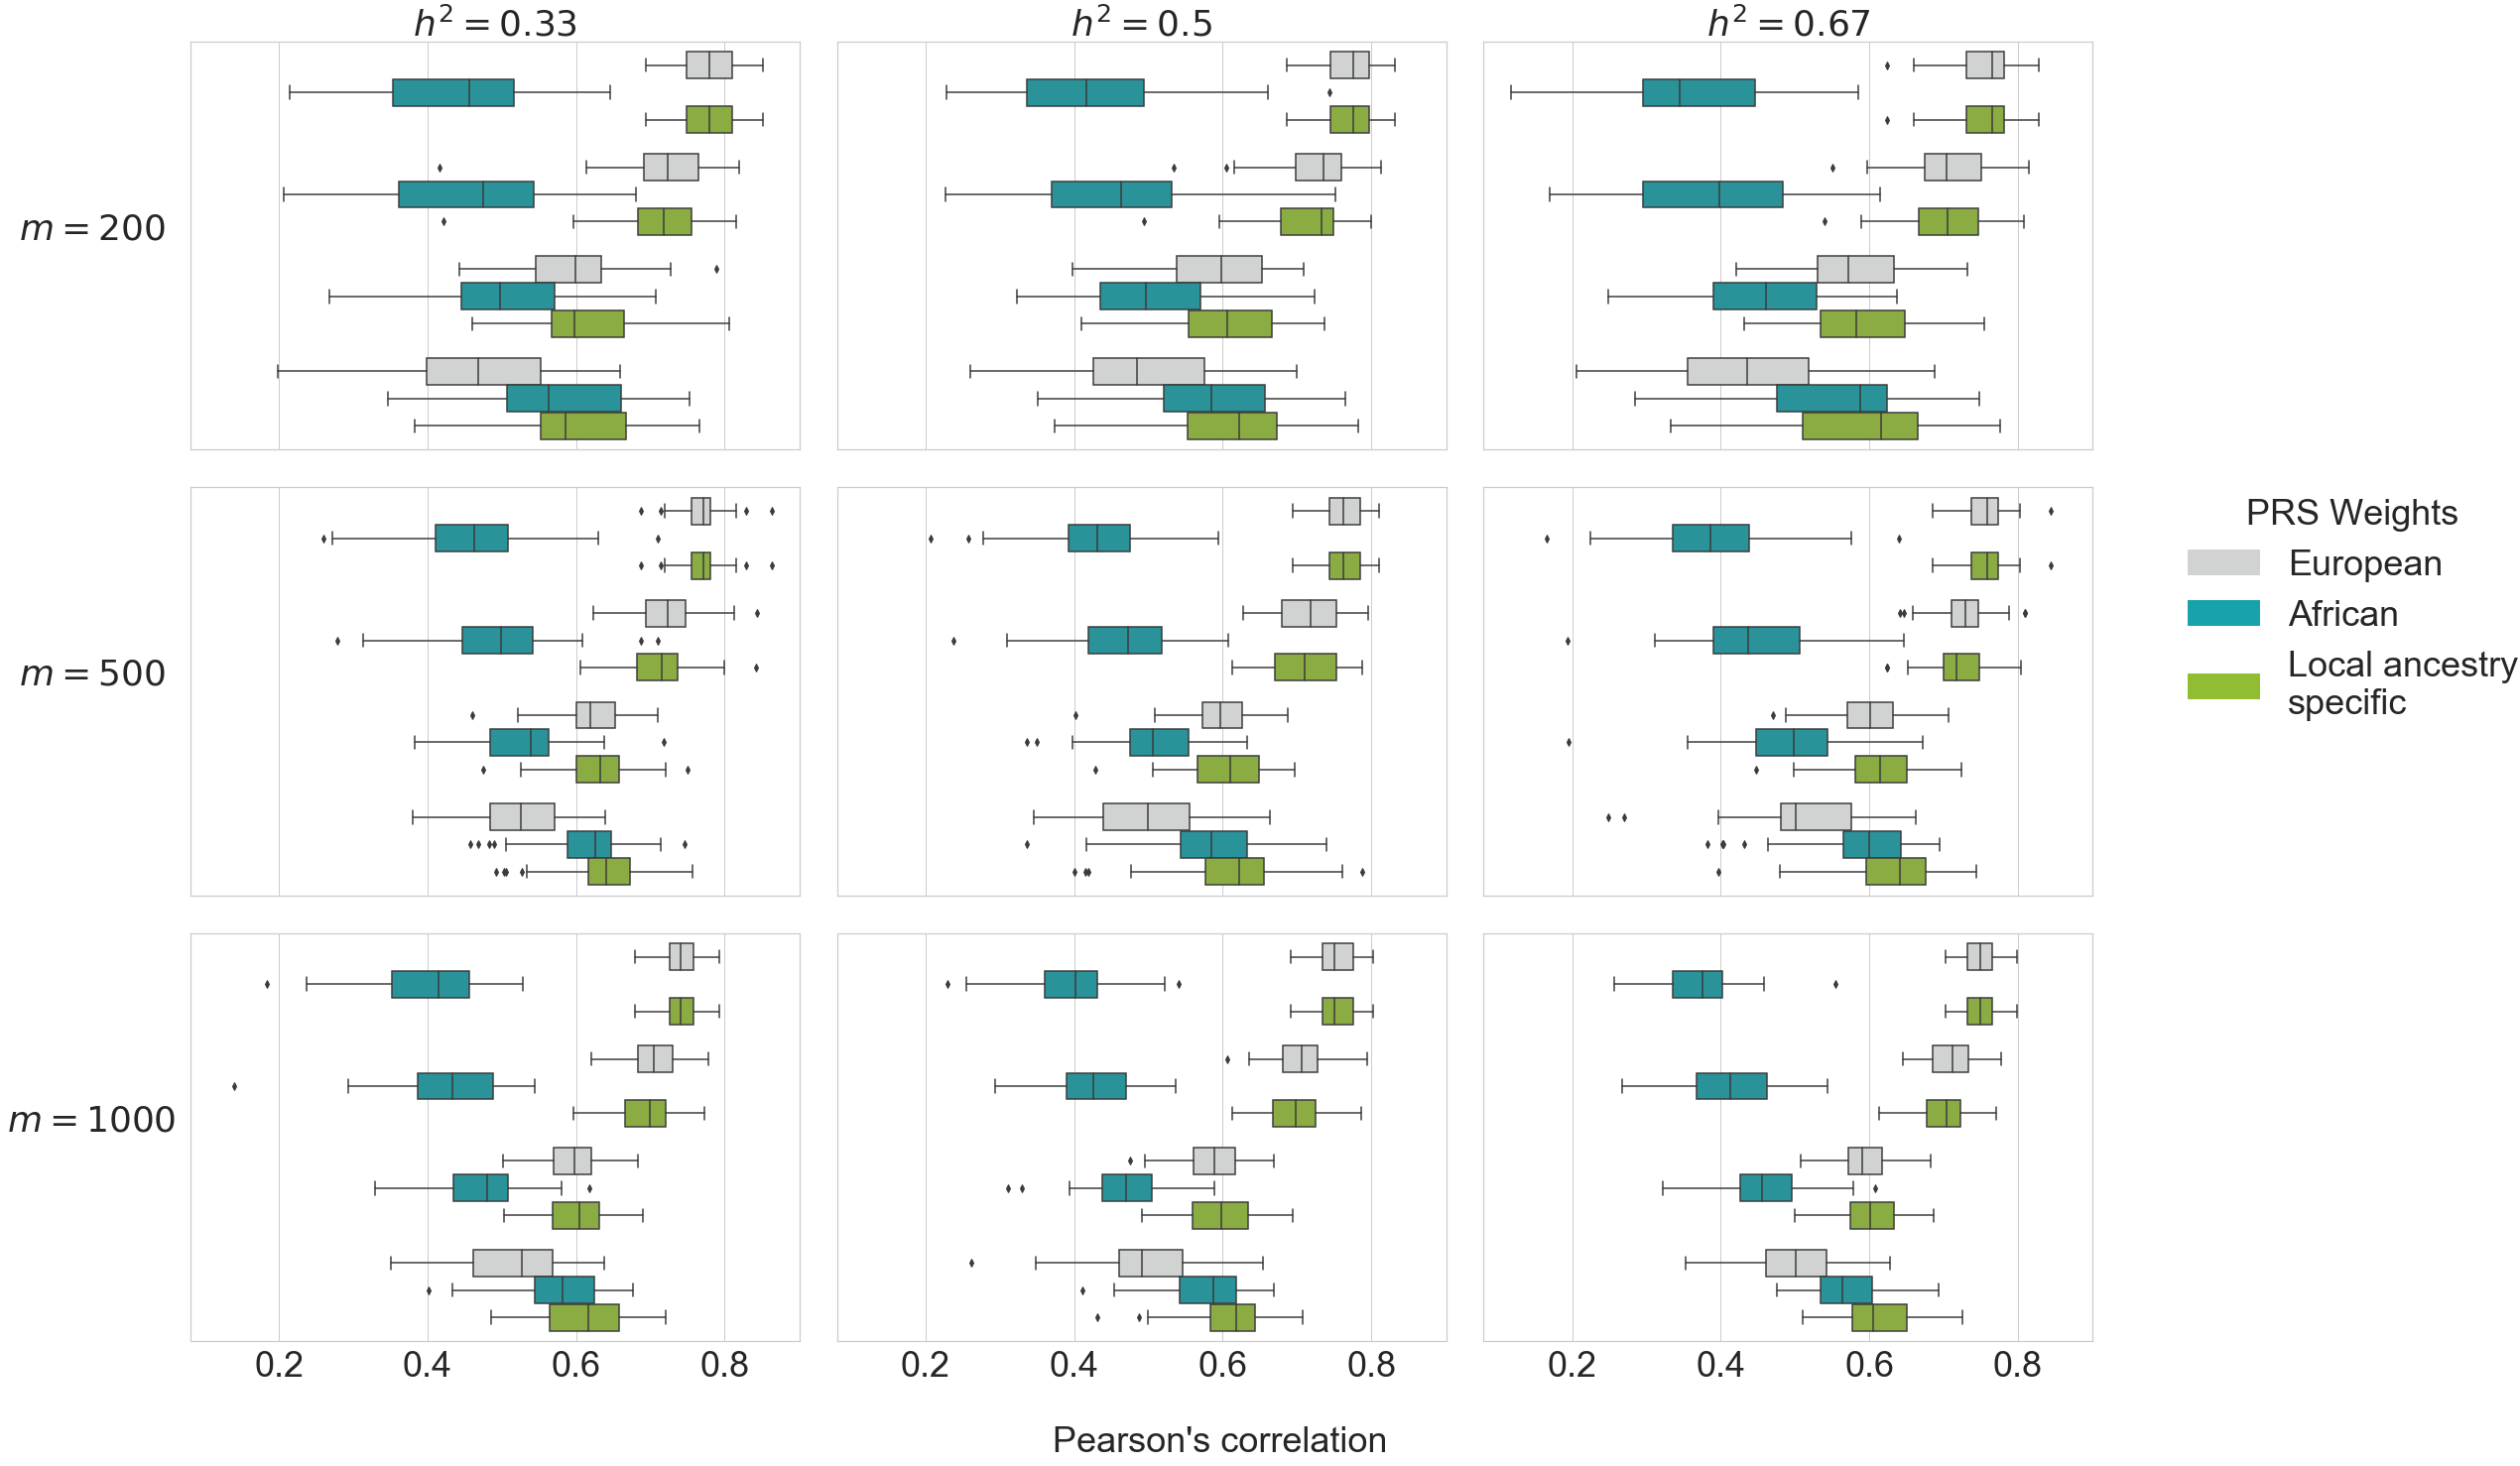

In [57]:
fig,ax = plt.subplots(3,3,figsize=(30,20),sharey = True, sharex = True)

for num, axes in enumerate(ax.T.ravel()):
    g = sns.boxplot(y="variable",x="value",hue="weight",hue_order = ["European","African","Local ancestry \nspecific"],
                   data=long_df[(long_df["m"]==pairs[num][1])&(long_df["h2"]==pairs[num][0])],ax=axes,palette=["#D1D3D3","#18A3AC","#90BD31"])
    axes.get_legend().set_visible(False)
    axes.set_ylabel("")
    axes.set_xlabel("")
    axes.set_yticklabels("")
    axes.tick_params(axis="both",labelsize=36)

for i in range(3):
    ax[i,0].set_ylabel(r"$m = {}$".format(m[i]),fontsize=36,rotation=0,labelpad=90)
    ax[0,i].set_title(r"$h^2 = {}$".format(h2[i]),fontsize=36)

legend_dict = dict(zip(["European","African","Local ancestry\nspecific"],["#D1D3D3","#18A3AC","#90BD31"]))
patchList = []
for key in legend_dict:
    data_key = mpatches.Patch(color=legend_dict[key], label=key)
    patchList.append(data_key)

fig.text(x=0.5,y=-0.03,s=r"Pearson's correlation",rotation=0,fontsize=36)
legend = fig.legend(bbox_to_anchor=(1.19,0.7),handles=patchList,fancybox=False,frameon=False,fontsize=36,title="PRS Weights")
plt.setp(legend.get_title(),fontsize=36)
plt.tight_layout()
# plt.savefig("/Users/taylorcavazos/Desktop/WEIGHT_corrs_m_h2.png",astype="png",
#            bbox_inches="tight",dpi=1000)
plt.show()

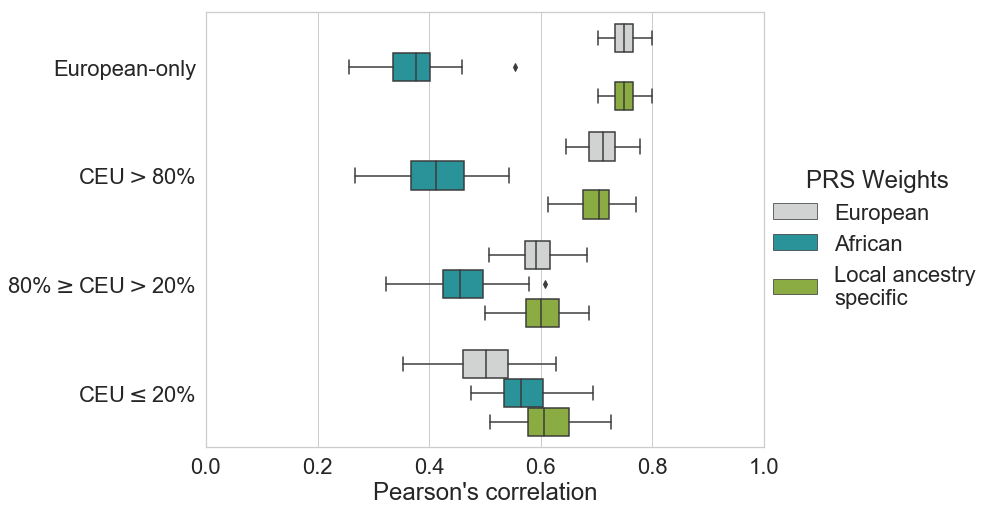

In [57]:
fig,ax = plt.subplots(figsize=(10,8))
g = sns.boxplot(y="variable",x="value",hue="weight",hue_order = ["European","African","Local ancestry \nspecific"],
                   data=long_df[(long_df["m"]==1000)&(long_df["h2"]==0.67)],ax=ax,palette=["#D1D3D3","#18A3AC","#90BD31"])


g.set_xticks(np.arange(0,1.2,0.2))
g.set_yticklabels(["European-only","CEU$>$80%","80%$\geq$CEU$>$20%", "CEU$\leq$20%"],
                 rotation=0)
# #sns.despine(right=True)
legend = plt.legend(frameon=False,title="PRS Weights",fancybox=False,loc=(1,0.3))
# plt.setp(legend.get_title(),fontsize=38)


# ax.tick_params(axis='both', which='major', labelsize=38)
# ax.tick_params(axis='both', which='minor', labelsize=38)

# # plt.title("Local Ancestry Weighting ")
plt.ylabel("")
plt.xlabel("Pearson's correlation")
# # plt.savefig("/Users/taylorcavazos/Documents/Posters/ASHG2019/alt_layout_1/result4.png",dpi=1000,bbox_inches="tight")

# plt.savefig("/Users/taylorcavazos/Box Sync/all_weights.png",dpi=1000,bbox_inches="tight")

plt.show()



In [29]:
afr = long_df.loc[(long_df["weight"]=="African")&(long_df["variable"]=="ADMIX_mid_eur_corr"),"value"]

In [30]:
localAnc = long_df.loc[(long_df["weight"]=="Local ancestry \nspecific")&(long_df["variable"]=="ADMIX_mid_eur_corr"),"value"]

In [31]:
from scipy import stats

In [32]:
stats.ttest_rel(list(afr),list(localAnc))

Ttest_relResult(statistic=-5.858408086584685, pvalue=5.701649808919634e-06)

In [35]:
full_df_prs = full_df_prs.sort_index()

In [38]:
test = full_df_prs.loc[(full_df_prs["weight"]=="Local ancestry \nspecific")|(full_df_prs["weight"]=="African")].reset_index()

In [40]:
test.sort_values(["index","weight"])

,index,ADMIX_high_eur_corr,ADMIX_low_eur_corr,ADMIX_mid_eur_corr,test_ADMIX_corr,test_EUR_corr,train_corr,weight
0,51,0.376736,0.590946,0.439298,0.425122,0.303812,0.371122,African
1,51,0.663789,0.591780,0.512927,0.469145,0.749068,0.845436,Local ancestry \nspecific
3,52,0.248449,0.473623,0.376723,0.336579,0.293591,0.367578,African
2,52,0.636176,0.508311,0.477068,0.478166,0.756384,0.854227,Local ancestry \nspecific
4,53,0.362934,0.609950,0.474603,0.475899,0.341723,0.406594,African
5,53,0.737030,0.632037,0.608986,0.621530,0.776449,0.859186,Local ancestry \nspecific
6,54,0.496242,0.630594,0.564710,0.559573,0.398213,0.467961,African
7,54,0.711881,0.673073,0.654052,0.654508,0.752025,0.859248,Local ancestry \nspecific
9,55,0.318165,0.518102,0.455769,0.427586,0.354054,0.435151,African
8,55,0.651027,0.555438,0.546636,0.535750,0.721792,0.845944,Local ancestry \nspecific
